In [371]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim 
import tushare as ts 

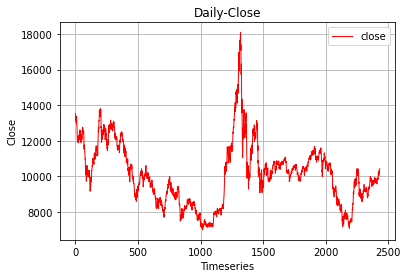

In [390]:
s_data = pd.read_csv('./Data/399001.SZ.csv', parse_dates=True)
s_data_copy = s_data
t = 3000
plt.plot(s_data["close"][:t],'r',lw = 1)
plt.legend(["close"])
plt.grid(True)
plt.axis("tight")
plt.xlabel("Timeseries")
plt.ylabel("Close")
plt.title("Daily-Close")
plt.savefig('SZSE.png')
plt.show()

In [391]:
#定义训练集
data_csv = pd.read_csv('./data/399001.SZ.csv')
use_cols = ['close']
data_csv = data_csv [use_cols]
data_csv = data_csv.dropna()
# 为了归一化后复现原来数据
close_min = data_csv['close'].min()
close_max = data_csv['close'].max()
# 归一化处理（0，1）
data_csv=data_csv.apply(lambda x:(x-min(x))/(max(x)-min(x)))
data_csv.head()

close
0  0.588765
1  0.587309
2  0.586211
3  0.561914
4  0.564793

In [392]:
import numpy as np 
# 序列长度为5，即用前5的数据预测之后一天的数据
sequence = 30
X = []
Y = []
for i in range(data_csv.shape[0]-sequence):
    # 选择use_cols作为特征
    X.append(np.array(data_csv.iloc[i:(i+sequence)].values, dtype=np.float))
    # 选择close作为标签输出
    Y.append(np.array(data_csv.iloc[(i+sequence)],dtype=np.float))

In [393]:
trainx, trainy = X[:int(0.7*data_csv.shape[0])], Y[:int(0.7*data_csv.shape[0])]
testx, testy = X[int(0.7*data_csv.shape[0]):], Y[int(0.7*data_csv.shape[0]):]

print(len(trainx))
print(len(testx))

1701
700


In [394]:
torch.manual_seed(1)

In [395]:
# list -> numpy
trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)


trainx = trainx.reshape(-1,1, sequence)  # (seq_size, batch_size, feature_size)
trainy = trainy.reshape(-1,1, 1)
testx = testx.reshape(-1, 1,sequence)  # (seq_size, batch_size, feature_size)

print('------------')
print(trainx.shape)
print(trainy.shape)
print(testx.shape)

# numpy -> torch
trainx = torch.from_numpy(trainx)
trainy = torch.from_numpy(trainy)
testx = torch.from_numpy(testx)
testy = torch.from_numpy(testy)


print('trainx size: ', trainx.size())
print('trainy size: ', trainy.size())
print('testx size: ', testx.size())
print('testy size: ', testy.size())

------------
(1701, 1, 30)
(1701, 1, 1)
(700, 1, 30)
trainx size:  torch.Size([1701, 1, 30])
trainy size:  torch.Size([1701, 1, 1])
testx size:  torch.Size([700, 1, 30])
testy size:  torch.Size([700, 1])


In [396]:
class BP(nn.Module):
    def __init__(self,in_feature,hidden_size,n_class):
        super(BP, self).__init__()
        self.BP = nn.Sequential(
        nn.Linear(in_feature, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, n_class),
        nn.Sigmoid(),
        )

    ##此处input的尺寸为[seq_len,batch,in_feature]
    def forward(self,input):
        output = self.BP(input)  # input, size (seq_len, batch, input_size)
        
        return output

In [397]:
input_size = 30      #一个序列的长度,也就是输入特征数
n_hidden = 30      #隐层神经元数目
target_size = 1     #输出的尺寸

In [398]:
model = BP(in_feature=input_size,hidden_size=n_hidden,n_class=target_size)
print(model)

BP(
  (BP): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [399]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [400]:
trainx = Variable(trainx).float()
trainy = Variable(trainy).float()
testx = Variable(testx).float()
testy = Variable(testy).float()
print (trainx.shape)
print (trainy.shape)
print (testx.shape)
print (testy.shape)

torch.Size([1701, 1, 30])
torch.Size([1701, 1, 1])
torch.Size([700, 1, 30])
torch.Size([700, 1])


In [401]:
for epoch in range(100):                   
    out = model(trainx)
    loss = loss_function(out, trainy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  

    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))

Epoch: 10, Loss:0.06275
Epoch: 20, Loss:0.05564
Epoch: 30, Loss:0.05320
Epoch: 40, Loss:0.05068
Epoch: 50, Loss:0.04764
Epoch: 60, Loss:0.04452
Epoch: 70, Loss:0.04120
Epoch: 80, Loss:0.03764
Epoch: 90, Loss:0.03395
Epoch: 100, Loss:0.03022


torch.Size([1701, 1, 1])


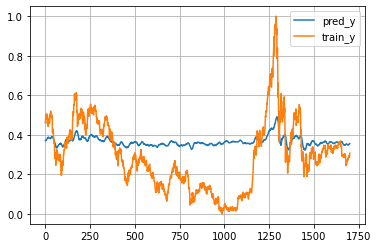

In [402]:
model = model.eval()
output_train=model(trainx)
print(output_train.shape)

plt.plot(output_train.data.numpy().reshape(1701,1), label='pred_y')
plt.plot(trainy.reshape(1701,1), label='train_y')
plt.grid(True)
plt.axis("tight")
plt.legend()
plt.show()

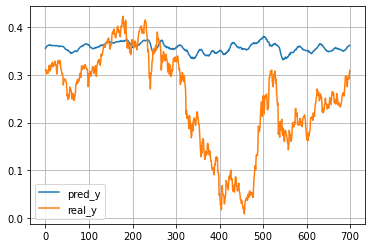

In [403]:
# 测试集输入模型进行预测
model = model.eval() # 让model变成测试模式（训练效果图）
output_pred = model(testx)

plt.plot(output_pred.data.numpy().reshape(700,1),label='pred_y')
plt.plot(testy.reshape(700,1),label='real_y')
plt.legend()
plt.grid(True)
plt.axis("tight")
plt.savefig("FFBPN-Prediction(SZSE).png")
plt.show()

In [404]:
pred = output_pred.data.numpy().reshape(700,1)
real = testy.reshape(700,1)
print(pred.shape)
print(real.shape)

(700, 1)
torch.Size([700, 1])


In [405]:
mse = mean_squared_error(pred, real)
rmse = math.sqrt(mean_squared_error(pred, real))
mae = mean_absolute_error(pred, real)
print('mean_squared_error: %.6f' % mse)
print('root_mean_squared_error: %.6f' % rmse)
print('mean_absolute_error: %.6f' % mae)

mean_squared_error: 0.021531
root_mean_squared_error: 0.146734
mean_absolute_error: 0.113927
